# MODELO LSTM PARA SERIES TEMPORALES DE PRECIO (TRADING ALGORITMICO)

# IMPORTACIONES NECESARIAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Configuración

In [2]:
plt.style.use('default') 
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Carga de datos

In [3]:
def load_data(filepath, symbol, date_col='datetime', price_col='Close'):
    """
    Carga datos históricos para un símbolo específico desde un archivo CSV.
    
    Args:
        filepath: Ruta al archivo CSV
        symbol: Símbolo del activo a cargar (ej. 'BTC-USD')
        date_col: Nombre de la columna de fecha
        price_col: Nombre de la columna de precio a predecir
        
    Returns:
        DataFrame con los datos del activo
    """
    try:
        # Cargar todos los datos
        df = pd.read_csv(filepath)
        
        # Verificar que las columnas necesarias existan
        required_cols = ['symbol', date_col, price_col, 'Open', 'High', 'Low', 'Volume']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Advertencia: Columnas faltantes: {missing_cols}")
            # Usar solo las columnas disponibles
            available_cols = [col for col in required_cols if col in df.columns]
            if 'symbol' not in available_cols or price_col not in available_cols:
                raise ValueError(f"Columnas críticas faltantes: symbol o {price_col}")
        
        # Filtrar por símbolo (manejo más robusto de comparación)
        df_filtered = df[df['symbol'].astype(str).str.upper() == symbol.upper()].copy()
        
        if df_filtered.empty:
            print(f"Símbolos disponibles: {df['symbol'].unique()}")
            raise ValueError(f"No se encontraron datos para el símbolo {symbol}")
            
        # Convertir columna de fecha
        df_filtered[date_col] = pd.to_datetime(df_filtered[date_col])
        df_filtered.set_index(date_col, inplace=True)
        
        # Ordenar por fecha
        df_filtered.sort_index(inplace=True)
        
        # Seleccionar columnas disponibles para el análisis
        base_cols = [price_col]
        optional_cols = ['Open', 'High', 'Low', 'Volume']
        final_cols = base_cols + [col for col in optional_cols if col in df_filtered.columns]
        
        result_df = df_filtered[final_cols].copy()
        
        # Eliminar filas con valores nulos en la columna de precio
        result_df.dropna(subset=[price_col], inplace=True)
        
        print(f"Datos cargados exitosamente para {symbol}")
        print(f"Período: {result_df.index.min()} a {result_df.index.max()}")
        print(f"Total de registros: {len(result_df)}")
        print(f"Columnas disponibles: {result_df.columns.tolist()}")
        
        return result_df
        
    except Exception as e:
        print(f"Error al cargar datos: {str(e)}")
        return pd.DataFrame()

# 2. Preprocesamiento y creación de características

In [4]:
def preprocess_data(df, lookback=60, test_size=0.2, price_col='Close'):
    """
    Preprocesa los datos y crea secuencias para el modelo LSTM.
    
    Args:
        df: DataFrame con los datos
        lookback: Número de períodos a mirar hacia atrás
        test_size: Proporción de datos para test
        price_col: Nombre de la columna de precio
        
    Returns:
        Tupla con datos de entrenamiento y prueba
    """
    print(f"Datos originales: {len(df)} registros")
    
    # Verificar que tenemos suficientes datos
    if len(df) < lookback + 50:  # Mínimo para entrenar
        raise ValueError(f"Necesitas al menos {lookback + 50} registros, tienes {len(df)}")
    
    # Crear características técnicas solo si tenemos las columnas necesarias
    features_df = df.copy()
    
    # Indicadores técnicos básicos
    features_df['returns'] = features_df[price_col].pct_change()
    features_df['sma_10'] = features_df[price_col].rolling(10, min_periods=1).mean()
    features_df['sma_30'] = features_df[price_col].rolling(30, min_periods=1).mean()
    
    # Solo agregar volumen si está disponible
    if 'Volume' in features_df.columns:
        features_df['Volume_sma'] = features_df['Volume'].rolling(10, min_periods=1).mean()
        # Rellenar NaNs en volumen con la mediana
        features_df['Volume'].fillna(features_df['Volume'].median(), inplace=True)
        features_df['Volume_sma'].fillna(features_df['Volume_sma'].median(), inplace=True)
    
    # Rellenar valores NaN con forward fill y backward fill
    features_df.fillna(method='ffill', inplace=True)
    features_df.fillna(method='bfill', inplace=True)
    
    # Eliminar cualquier NaN restante
    features_df.dropna(inplace=True)
    
    print(f"Datos después de crear características: {len(features_df)} registros")
    
    # Escalar los datos usando MinMaxScaler (mejor para precios)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(features_df.values)
    
    # Crear secuencias
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        # El índice 0 corresponde al precio de cierre
        price_col_idx = features_df.columns.get_loc(price_col)
        y.append(scaled_data[i, price_col_idx])
        
    X, y = np.array(X), np.array(y)
    
    # Dividir en train y test manteniendo orden temporal
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Datos preparados:")
    print(f"- Secuencias de entrenamiento: {len(X_train)}")
    print(f"- Secuencias de prueba: {len(X_test)}")
    print(f"- Lookback: {lookback} períodos")
    print(f"- Características por período: {X.shape[2]}")
    
    return X_train, X_test, y_train, y_test, scaler, features_df.columns

# 3. Modelo LSTM

In [5]:
def build_model(input_shape, dropout_rate=0.2):
    """
    Construye un modelo LSTM con regularización.
    
    Args:
        input_shape: Forma de los datos de entrada (lookback, n_features)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo de Keras compilado
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print("Modelo construido:")
    model.summary()
    
    return model

## 4. Entrenamiento y evaluación

def train_and_evaluate(model, X_train, X_test, y_train, y_test, epochs=100, batch_size=32):
    """
    Entrena y evalúa el modelo.
    
    Args:
        model: Modelo de Keras
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
        epochs: Número máximo de épocas
        batch_size: Tamaño del batch
        
    Returns:
        Historia del entrenamiento y predicciones
    """
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
    
    print("Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Realizar predicciones
    print("Generando predicciones...")
    y_pred = model.predict(X_test, verbose=0)
    
    # Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print("\nEvaluación del modelo:")
    print(f"- MSE: {mse:.6f}")
    print(f"- RMSE: {rmse:.6f}")
    print(f"- MAE: {mae:.6f}")
    
    return history, y_pred

# 4. Entrenamiento y evaluación

In [6]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, epochs=100, batch_size=32):
    """
    Entrena y evalúa el modelo.
    
    Args:
        model: Modelo de Keras
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
        epochs: Número máximo de épocas
        batch_size: Tamaño del batch
        
    Returns:
        Historia del entrenamiento y predicciones
    """
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
    
    print("Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Realizar predicciones
    print("Generando predicciones...")
    y_pred = model.predict(X_test, verbose=0)
    
    # Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print("\nEvaluación del modelo:")
    print(f"- MSE: {mse:.6f}")
    print(f"- RMSE: {rmse:.6f}")
    print(f"- MAE: {mae:.6f}")
    
    return history, y_pred

# 5. Visualización de resultados

In [7]:
def plot_results(df, y_test, y_pred, scaler, column_names, lookback, test_size=0.2, price_col='Close'):
    """
    Visualiza los resultados del modelo.
    
    Args:
        df: DataFrame original con los datos
        y_test: Valores reales escalados
        y_pred: Predicciones escaladas
        scaler: Objeto scaler usado
        column_names: Nombres de las columnas
        lookback: Períodos de lookback usados
        test_size: Proporción de datos usados para test
        price_col: Nombre de la columna de precio
    """
    # Obtener el índice de la columna de precio
    price_col_idx = list(column_names).index(price_col)
    
    # Crear arrays dummy para invertir el escalado
    n_features = len(column_names)
    
    # Para las predicciones
    dummy_pred = np.zeros((len(y_pred), n_features))
    dummy_pred[:, price_col_idx] = y_pred.flatten()
    y_pred_unscaled = scaler.inverse_transform(dummy_pred)[:, price_col_idx]
    
    # Para los valores reales
    dummy_test = np.zeros((len(y_test), n_features))
    dummy_test[:, price_col_idx] = y_test.flatten()
    y_test_unscaled = scaler.inverse_transform(dummy_test)[:, price_col_idx]
    
    # Crear fechas para el período de prueba
    # Ajustar el índice considerando las filas eliminadas por NaN
    total_available = len(df)
    split_idx = int(total_available * (1 - test_size))
    test_start_idx = split_idx
    test_dates = df.index[test_start_idx:test_start_idx + len(y_test)]
    
    # Asegurar que tenemos las fechas correctas
    if len(test_dates) != len(y_test_unscaled):
        # Usar las últimas fechas disponibles
        test_dates = df.index[-len(y_test_unscaled):]
    
    # Gráfico 1: Pérdida durante el entrenamiento
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Pérdida del Modelo Durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Gráfico 2: Predicciones vs reales
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test_unscaled, label='Valores Reales', alpha=0.8, linewidth=1)
    plt.plot(test_dates, y_pred_unscaled, label='Predicciones', alpha=0.8, linewidth=1)
    plt.title(f'Predicciones vs Valores Reales - {price_col.upper()}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Gráfico 3: Dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_unscaled, y_pred_unscaled, alpha=0.6, s=10)
    min_val, max_val = min(y_test_unscaled.min(), y_pred_unscaled.min()), max(y_test_unscaled.max(), y_pred_unscaled.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')
    plt.title('Dispersión: Predicciones vs Valores Reales')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Gráfico 4: Error absoluto
    error = np.abs(y_test_unscaled - y_pred_unscaled)
    plt.figure(figsize=(12, 4))
    plt.plot(test_dates, error, alpha=0.7)
    plt.title('Error Absoluto de las Predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Error Absoluto')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Estadísticas del error
    print("\nEstadísticas del error:")
    print(f"Error promedio: {error.mean():.4f}")
    print(f"Error mediano: {np.median(error):.4f}")
    print(f"Error máximo: {error.max():.4f}")
    print(f"Error mínimo: {error.min():.4f}")

# 6. Flujo principal de ejecución

=== MODELO LSTM PARA PREDICCIÓN DE PRECIOS ===

1. CARGANDO DATOS...
Datos cargados exitosamente para EURUSD=X
Período: 2015-08-04 00:00:00 a 2025-07-31 00:00:00
Total de registros: 2602
Columnas disponibles: ['Close', 'Open', 'High', 'Low', 'Volume']

2. PREPROCESANDO DATOS...
Datos originales: 2602 registros
Datos después de crear características: 2602 registros
Datos preparados:
- Secuencias de entrenamiento: 2033
- Secuencias de prueba: 509
- Lookback: 60 períodos
- Características por período: 9

3. CONSTRUYENDO MODELO...
Modelo construido:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (No

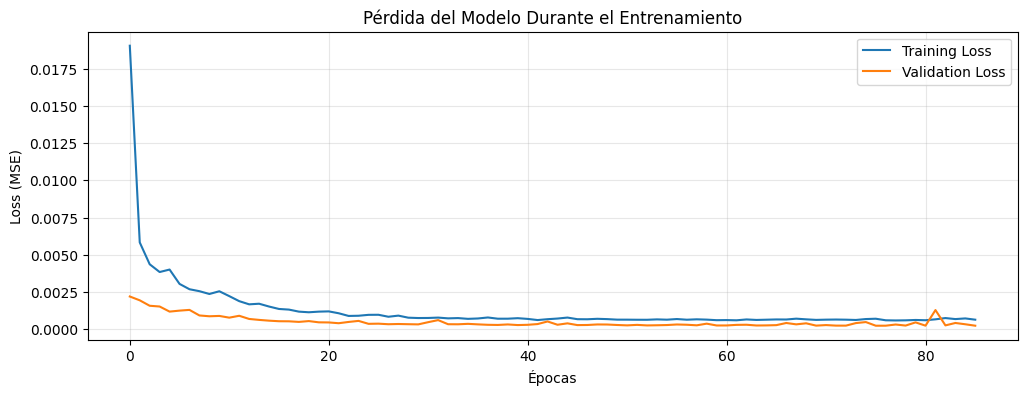

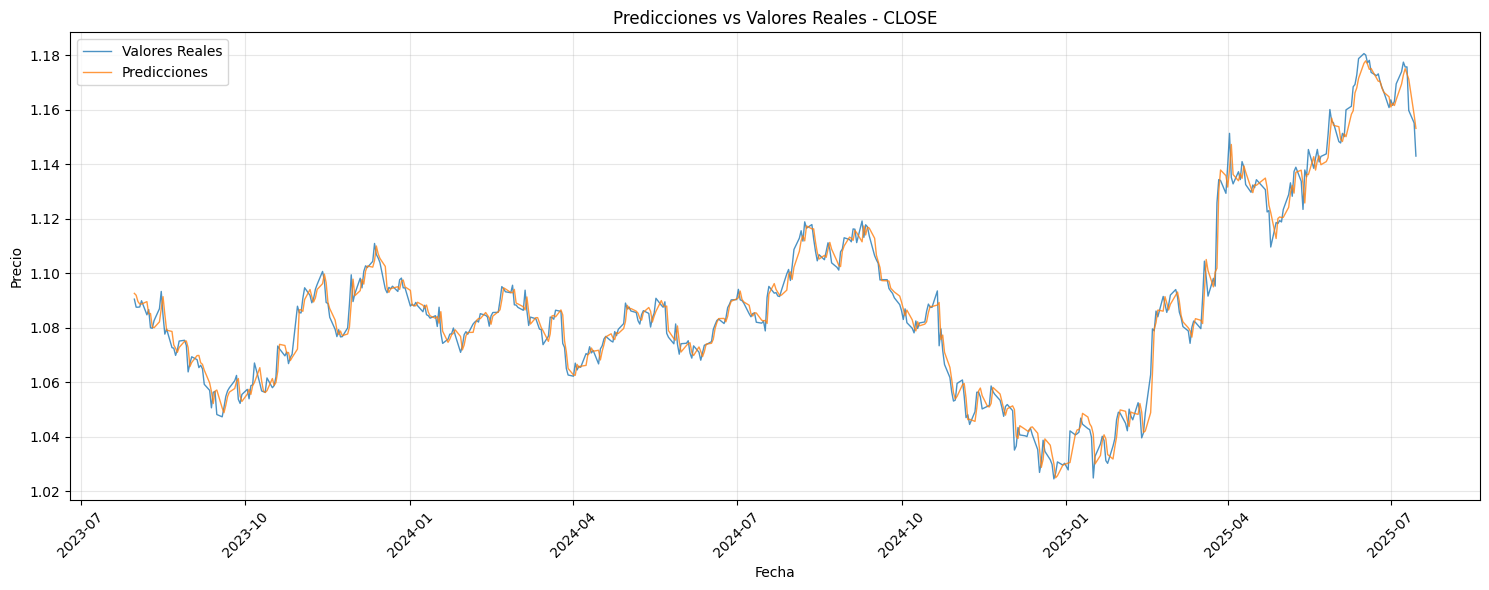

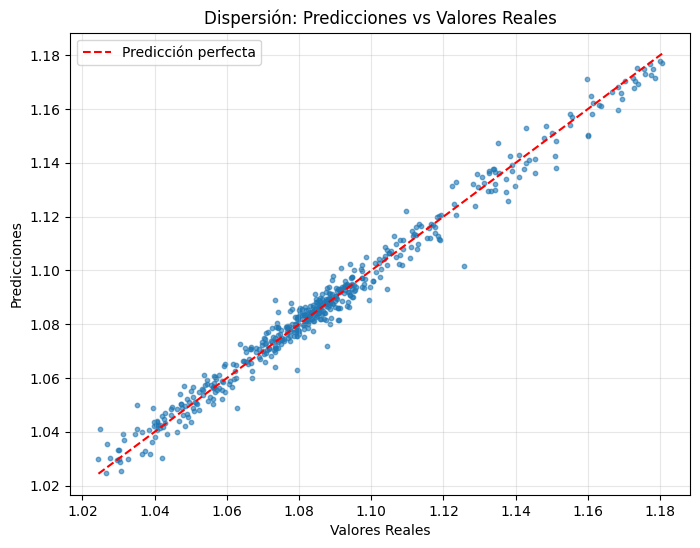

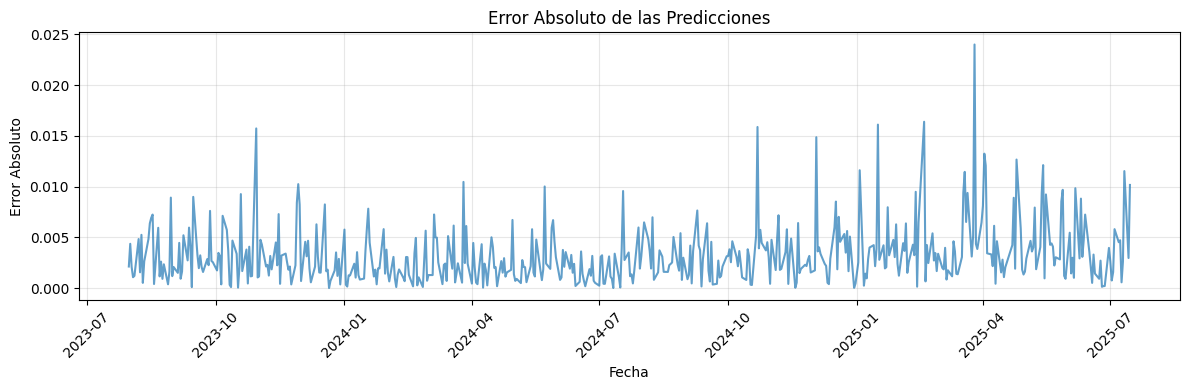


Estadísticas del error:
Error promedio: 0.0033
Error mediano: 0.0025
Error máximo: 0.0240
Error mínimo: 0.0000

=== PROCESO COMPLETADO EXITOSAMENTE ===


In [ ]:
def main():
    """Función principal que ejecuta todo el pipeline"""
    
    # Configuración
    filepath = "C:/Users/Paúl/Desktop/JupyterProyectos/Proyectos/todos_1d_10y.csv"  # Cambiar ruta
    symbol = "EURUSD=X"  # Cambiar por el símbolo deseado
    lookback = 60  # Períodos a mirar hacia atrás
    test_size = 0.2  # Proporción para test
    epochs = 100  # Máximo de épocas
    batch_size = 32  # Tamaño del batch
    
    print("=== MODELO LSTM PARA PREDICCIÓN DE PRECIOS ===\n")
    
    try:
        # 1. Cargar datos
        print("1. CARGANDO DATOS...")
        df = load_data(filepath, symbol)
        if df.empty:
            print("No se pudieron cargar los datos. Verifica el archivo y el símbolo.")
            return
        
        # 2. Preprocesar datos
        print("\n2. PREPROCESANDO DATOS...")
        X_train, X_test, y_train, y_test, scaler, column_names = preprocess_data(
            df, lookback, test_size
        )
        
        # 3. Construir modelo
        print("\n3. CONSTRUYENDO MODELO...")
        model = build_model((X_train.shape[1], X_train.shape[2]))
        
        # 4. Entrenar y evaluar
        print("\n4. ENTRENANDO MODELO...")
        global history  # Para acceder desde plot_results
        history, y_pred = train_and_evaluate(
            model, X_train, X_test, y_train, y_test, epochs, batch_size
        )
        
        # 5. Visualizar resultados
        print("\n5. VISUALIZANDO RESULTADOS...")
        plot_results(df, y_test, y_pred, scaler, column_names, lookback, test_size)
        
        print("\n=== PROCESO COMPLETADO EXITOSAMENTE ===")
        
    except Exception as e:
        print(f"\nError durante la ejecución: {str(e)}")
        print("Verifica los datos de entrada y la configuración.")

# Ejecutar el programa principal
if __name__ == "__main__":
    main()